In [1]:
!pip install transformers

In [2]:
!pip install torch torchvision

In [71]:
from google.colab import drive,files
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip /content/drive/MyDrive/DS2021/Datasets/archive\(8\).zip 

Archive:  /content/drive/MyDrive/DS2021/Datasets/archive(8).zip
replace X_test_update.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N
N


In [5]:
import pandas as pd
import numpy as np 
from nltk import WordPunctTokenizer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords


Image Path
 training :" ../input/rakuten-france-multimodal-product-classification/images/images/image_test"
 
test: "../input/rakuten-france-multimodal-product-classification/images/images/image_train"


In [6]:
x_train = pd.read_csv("/content/X_train_update.csv")
y_train = pd.read_csv("/content/Y_train_CVw08PX.csv")
x_test = pd.read_csv("/content/X_test_update.csv")

In [7]:
x_train.columns

Index(['Unnamed: 0', 'designation', 'description', 'productid', 'imageid'], dtype='object')

In [8]:
x_train.head()

,Unnamed: 0,designation,description,productid,imageid
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


In [9]:
x_train.rename(columns={"Unnamed: 0": "Id"}, inplace=True)
y_train.rename(columns={"Unnamed: 0": "Id"}, inplace=True)
x_test.rename(columns={"Unnamed: 0": "Id"}, inplace=True)

In [10]:
x_train.describe()

,Id,productid,imageid
count,84916.000000,8.491600e+04,8.491600e+04
mean,42457.500000,2.555468e+09,1.152691e+09
std,24513.282066,1.588656e+09,1.751427e+08
min,0.000000,1.839120e+05,6.728400e+04
25%,21228.750000,6.760519e+08,1.056269e+09
50%,42457.500000,3.190506e+09,1.213354e+09
75%,63686.250000,3.995599e+09,1.275646e+09
max,84915.000000,4.252012e+09,1.328824e+09


In [11]:
y_train.describe()

,Id,prdtypecode
count,84916.000000,84916.000000
mean,42457.500000,1773.219900
std,24513.282066,788.179885
min,0.000000,10.000000
25%,21228.750000,1281.000000
50%,42457.500000,1920.000000
75%,63686.250000,2522.000000
max,84915.000000,2905.000000


In [12]:
h=y_train.prdtypecode.value_counts()

In [13]:
len(h)

27

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


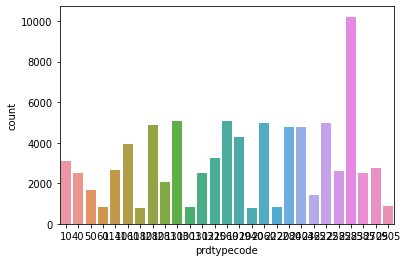

In [14]:
import seaborn as sns
sns.countplot(y_train.prdtypecode)

In [15]:
len(x_train)

84916

In [16]:
x_train.sample(5)

,Id,designation,description,productid,imageid
39694,39694,The Suffering - Ps2 - Playstation 2 - Edition ...,NaN,1651653704,1241447361
42634,42634,Nintendo Gamecube - Console De Jeux - Noir - M...,NaN,1805032441,1102674573
10445,10445,Ultra Soft Area Moderne Tapis Shaggy Tapis Nur...,Ultra Zone moderne doux tapis shaggy Nursery T...,4209068684,1316532644
46035,46035,Draeger Lot De 5 Stickers Mural L'ours Bleu Mu...,Sticker mural pour enfant composé d&#39;un our...,3876188970,1256969724
59558,59558,Surpasshobby Étanche 3650 4300kv Brushless 45a...,SurpassHobby étanche 3650 4300KV Brushless Sen...,4019800024,1277511313


In [17]:
y_train.sample(5)

,Id,prdtypecode
79356,79356,50
47227,47227,2905
50147,50147,2582
78163,78163,1560
23086,23086,2280


In [55]:
print(x_test.sample(5))

          Id  ...     imageid
3173   88089  ...  1100077520
13437  98353  ...  1156656894
676    85592  ...  1306803682
3856   88772  ...  1324007933
1358   86274  ...   848757863

[5 rows x 5 columns]


classifcation multinomiale non balance

In [19]:
!pip install sentencepiece

In [20]:
import torch
from transformers import CamembertTokenizer

model_name = "camembert-base"
tokenizer = CamembertTokenizer.from_pretrained(model_name)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Average length: 22.4
Max length: 104


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


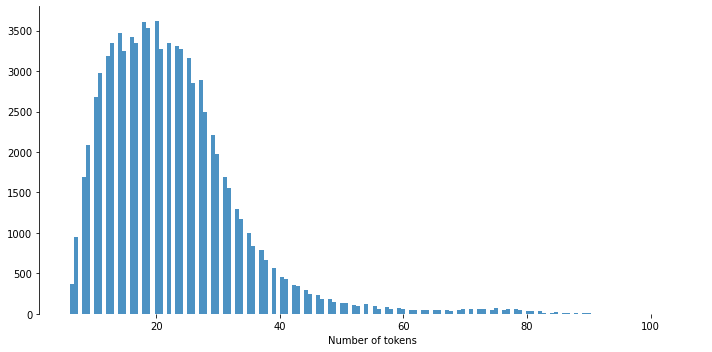

In [21]:
import matplotlib.pyplot as plt
reviews_len = [len(tokenizer.encode(review, max_length=512))
                          for review in x_train.designation.values]
print("Average length: {:.1f}".format(np.mean(reviews_len)))
print("Max length: {}".format(max(reviews_len)))

plt.figure(figsize=(10,5))
ax = sns.distplot(reviews_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Number of tokens')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig('./number_of_tokens.png', dpi=200)

In [22]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import spacy
import nltk
nltk.download('stopwords')
!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [23]:
class simple_Text_cleaner(BaseEstimator, TransformerMixin):
  # add another additional parameter, just for fun, while we are at it
    def __init__(self, stopwords,columns,tokenizer=WordPunctTokenizer()): 
        self.columns = columns
        self.stopwords = stopwords
        self.tokenizer=tokenizer
    def rm_stopwords(self,tokens):
        tokens=self.tokenizer.tokenize(tokens)
        return [ tk for tk in tokens if  tk not in self.stopwords ]
    def text_clean_up(self,s=""):
        import re
        user_pattern       = '@[^\s]+'
        s=re.sub(user_pattern, "", s)
        remove = '"#$%&()*+/:;<=>@[\\]^_`{|}~”“'
        pattern = r"[{}]".format(remove)
        s=re.sub(pattern,' ', s) 
        sequencePattern   = r"(.)\1\1+"
        seqReplacePattern = r"\1\1"
        s=re.sub(sequencePattern, seqReplacePattern, s)
        s=re.sub("<[^>]*>",' ', s)
        s=re.sub("[\r\n]+",' ', s)
        s=re.sub("http\S+",' ', s)
        s=re.sub("\$[^>]*\$",' ', s)
        s=re.sub("\d+",' ', s)
        s=re.sub("\s\s+",' ', s)
        s.strip()
        return s
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X_=X.copy()
        X_["image_path"]=(X_["imageid"].apply(lambda x: str(int(x)))+"_product_"+X_["productid"].apply(lambda x: str(int(x)))+".jpg").apply(lambda x: "image_"+x)
        for i in self.columns:84916
            X_[i]=X_[i].apply(lambda x: " ".join(self.rm_stopwords(self.text_clean_up(x))))
        return X_

In [24]:
stop_words = stopwords.words('french')
stop_words.extend(stopwords.words('english'))
cleaner=simple_Text_cleaner(stopwords=stop_words,columns=["designation"])
new_data=cleaner.transform(x_train)

image_imageid_product_productid.jpg.

Average length: 19.7
Max length: 114


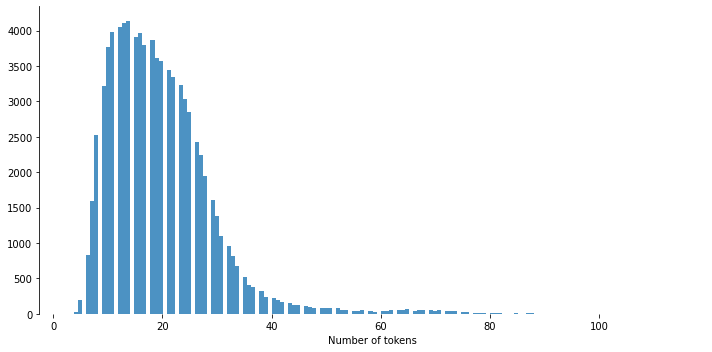

In [25]:
new_reviews_len = [len(tokenizer.encode(review, max_length=512))
                          for review in new_data.designation.values]
print("Average length: {:.1f}".format(np.mean(new_reviews_len)))
print("Max length: {}".format(max(new_reviews_len)))

plt.figure(figsize=(10,5))
ax = sns.distplot(new_reviews_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Number of tokens')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig('./number_of_tokens_clean.png', dpi=200)

On va travailler sur un max_length de 60 

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu=torch.device("cpu")

In [29]:
!pip install omegaconf
!pip install hydra-core

     |████████████████████████████████| 122kB 21.1MB/s 
     |████████████████████████████████| 112kB 40.6MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-cp36-none-any.whl size=141231 sha256=89b02d603a289e22d47874bea4902c7b56f04a4ac4276fed754dd0143ab4bb74
  Stored in directory: /root/.cache/pip/wheels/e3/e2/fa/b78480b448b8579ddf393bebd3f47ee23aa84c89b6a78285c8
Successfully built antlr4-python3-runtime


In [35]:
from transformers import CamembertModel, CamembertTokenizer

# You can replace "camembert-base" with any other model from the table, e.g. "camembert/camembert-large".
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
camembert = CamembertModel.from_pretrained("camembert-base")

camembert.eval()  # disable dropout (or leave in train mode to finetune)

import torch
# Tokenize in sub-words with SentencePiece
tokenized_sentence = tokenizer.tokenize("J'aime le camembert !")
# ['▁J', "'", 'aime', '▁le', '▁ca', 'member', 't', '▁!'] 
print(tokenized_sentence)
# 1-hot encode and add special starting and end tokens 
encoded_sentence = tokenizer.encode(tokenized_sentence)
# [5, 121, 11, 660, 16, 730, 25543, 110, 83, 6] 
# NB: Can be done in one step : tokenize.encode("J'aime le camembert !")
print(encoded_sentence)
# Feed tokens to Camembert as a torch tensor (batch dim 1)BERT
encoded_sentence = torch.tensor(encoded_sentence).unsqueeze(0)
embeddings= camembert(encoded_sentence)["last_hidden_state"]
#print(embeddings.size())
# embeddings.detach()
# embeddings.size torch.Size([1, 10, 768])
# tensor([[[-0.0254,  0.0235,  0.1027,  ..., -0.1459, -0.0205, -0.0116],
#         [ 0.0606, -0.1811, -0.0418,  ..., -0.1815,  0.0880, -0.0766],
#         [-0.1561, -0.1127,  0.2687,  ..., -0.0648,  0.0249,  0.0446],
#         ...,



from transformers import CamembertConfig
# (Need to reload the model with new config)
config = CamembertConfig.from_pretrained("camembert-base", output_hidden_states=True)
camembert = CamembertModel.from_pretrained("camembert-base", config=config)
camembert.eval()  # disable dropout (or leave in train mode to finetune)

all_layer_embeddings = camembert(encoded_sentence)[2]
#  all_layer_embeddings list of len(all_layer_embeddings) == 13 (input embedding layer + 12 self attention layers)
all_layer_embeddings[5]
print(len(all_layer_embeddings))
# layer 5 contextual embedding : size torch.Size([1, 10, 768])
#tensor([[[-0.0032,  0.0075,  0.0040,  ..., -0.0025, -0.0178, -0.0210],
#         [-0.0996, -0.1474,  0.1057,  ..., -0.0278,  0.1690, -0.2982],
#         [ 0.0557,

['▁J', "'", 'aime', '▁le', '▁ca', 'member', 't', '▁!']
[5, 121, 11, 660, 16, 730, 25543, 110, 83, 6]
13


In [40]:
all_layer_embeddings[0].size()

torch.Size([1, 10, 768])

In [ ]:
def encode_reviews(tokenizer, reviews, max_length):
    token_ids = np.zeros(shape=(len(reviews), max_length),
                         dtype=np.int32)
    for i, review in enumerate(reviews):
        encoded = tokenizer.encode(review, max_length=max_length)
        token_ids[i, 0:len(encoded)] = encoded
    attention_mask = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_mask": attention_mask}


In [ ]:
class CamembertPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, tokenizer, max_seq_length,column):
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
        self.column=column
    def fit(self, X=None):
        return self 
    
    def transform(self, X, y):
        # 1. Tokenize
        X_encoded=X.copy()
        X_encoded[self.column] = encode_reviews(self.tokenizer, X[columns], self.max_seq_length)
        return X_encoded     
    
    def fit_transform(self, X, y):        
        return self.transform(X, y)

In [ ]:
MAX_SEQ_LEN = 60 # in terms of generated tokens (not words)

short_reviews = sum(np.array(reviews_len) <= MAX_SEQ_LEN)
long_reviews = sum(np.array(reviews_len) > MAX_SEQ_LEN)

print("{} reviews with LEN > {} ({:.2f} % of total data)".format(
    long_reviews,
    MAX_SEQ_LEN,
    100 * long_reviews / len(reviews_len)
))

Simple sentence embedding strategy: mean of second to last hidden layer

In [43]:
import torch.nn as nn 
import transformers as tt
from transformers import CamembertModel, CamembertTokenizer
class Second_to_last_SentenceEmbedding(nn.Module):
    def __init__(self):
        #super(, self).__init__()
        super().__init__()
        self.config = CamembertConfig.from_pretrained("camembert-base", output_hidden_states=True)
        self.camembert =CamembertModel.from_pretrained("camembert-base", config=self.config)
        self.fc1=nn.Linear(768,100)
        self.relu=nn.ReLU()
        self.fc2=nn.Linear(100,27)
        for p in self.camembert.parameters():
            p.requires_grad_(False)
    def forward(self, input,attention_mask=None):
        hidden = self.camembert(input,attention_mask=attention_mask)[2]
        token_vecs=hidden[-2]
        x=torch.mean(token_vecs,dim=1)
      
        return torch.mean(token_vecs,dim=1)

In [44]:
model=Second_to_last_SentenceEmbedding().to(device)

In [45]:
model.eval()

Second_to_last_SentenceEmbedding(
  (camembert): CamembertModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [48]:
x_train.shape

(84916, 5)

In [51]:
model(encoded_sentence.to(device)).size()

torch.Size([1, 768])

In [49]:
tokenizer.encode_plus(
                        "J'aime le camembert !",                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'input_ids': tensor([[    5,   121,    11,   660,    16,   730, 25543,   110,    83,     6,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

- Loading Image 
First we will build a custom Dataset uitilitaries and a Data Loader

In [42]:
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


In [79]:
class MultimodalDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,tokenizer, input_csv_file, root_dir,max_length=60 , transform=None,Y_csv_file=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.input_file = pd.read_csv(input_csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.max_length=max_length
        self.input_file["image_path"]=(self.input_file["imageid"].apply(lambda x: str(int(x)))+"_product_"+self.input_file["productid"].apply(lambda x: str(int(x)))+".jpg").apply(lambda x: "image_"+x)
        if Y_csv_file !=None:
            self.output = pd.read_csv(Y_csv_file)
            self.classes = list(set(self.output["prdtypecode"].values))
        else:
            self.ouptut=None
    def __len__(self):
        return len(self.input_file)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,
                                self.input_file["image_path"].iloc[idx])
        image = io.imread(img_name)
        text = self.input_file["designation"].iloc[idx]
        encoded_text = tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
        sample = {'image': image, 'input_ids':encoded_text['input_ids'] ,'attention_mask':encoded_text['attention_mask']}

        if self.transform:
            sample['image'] = self.transform(sample['image'])
        if self.output is None:
            return sample
        sample["label"]=torch.tensor(self.classes.index(self.output["prdtypecode"].iloc[idx]))
        return sample

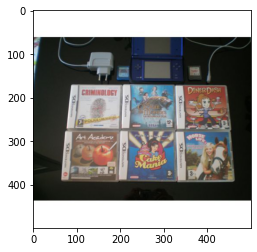

In [60]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
def show_landmarks(image):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('/content/images/images/image_train', new_data["image_path"].iloc[25])))
plt.show()

In [70]:
?np.random.random_integers

0 (500, 500, 3)


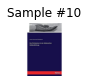

1 (500, 500, 3)


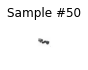

2 (500, 500, 3)


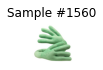

3 (500, 500, 3)


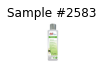

4 (500, 500, 3)


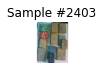

5 (500, 500, 3)


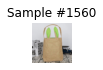

In [93]:
face_dataset = MultimodalDataset(tokenizer=tokenizer, input_csv_file="/content/X_train_update.csv", root_dir="/content/images/images/image_train",max_length=60 , transform=None,Y_csv_file="/content/Y_train_CVw08PX.csv")

fig = plt.figure()
l=np.random.random_integers(0,84916,6)
for i in range(len(l)):
    sample = face_dataset[l[i]]

    print(i, sample['image'].shape)

    ax = plt.subplot(1, 6, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(face_dataset.classes[sample["label"]]))
    ax.axis('off')
    show_landmarks(sample["image"])
    plt.show()

In [91]:
4%3

1

In [63]:
height=[]
width=[]
for i in range(84916):
  image=io.imread(os.path.join('/content/images/images/image_train', new_data["image_path"].iloc[i]))
  height.append(image.shape[0])
  width.append(image.shape[1])

Training Dataset

Image Transformation (Data Augmentation)

In [94]:
class Microscope:
    """
    Cutting out the edges around the center circle of the image
    Imitating a picture, taken through the microscope

    Args:
        p (float): probability of applying an augmentation
    """

    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to apply transformation to.

        Returns:
            PIL Image: Image with transformation.
        """
        if random.random() < self.p:
            circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
                        (img.shape[0]//2, img.shape[1]//2), # center point of circle
                        random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15), # radius
                        (0, 0, 0), # color
                        -1)

            mask = circle - 255
            img = np.multiply(img, mask)
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

In [ ]:
train_transform = transforms.Compose([
    Microscope(p=0.5),
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(size=384, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])